# Combined Evaluation Results Analysis

This notebook loads and analyzes the combined results from all evaluation batches.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import pandas as pd

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

In [3]:
# Directory where results will be stored
combined_dir = '/scratch/gpfs/jr8867/evals/protein-embeddings-norm/combined_results'
os.makedirs(combined_dir, exist_ok=True)

# Base directory containing batch results
base_dir = '/scratch/gpfs/jr8867/evals/protein-embeddings-norm'

# Find all batch directories
batch_dirs = [d for d in os.listdir(base_dir) if d.startswith('batch-')]
print(f"Found {len(batch_dirs)} batch directories")

# Initialize lists to store combined data
all_scores = []
all_labels = []

# Load and combine data from each batch
for batch_dir in batch_dirs:
    batch_path = os.path.join(base_dir, batch_dir)
    
    # Find score and label files in this batch directory
    score_files = [f for f in os.listdir(batch_path) if f.startswith('scores_batch_') and f.endswith('.npy')]
    label_files = [f for f in os.listdir(batch_path) if f.startswith('labels_batch_') and f.endswith('.npy')]
    
    for score_file in score_files:
        score_path = os.path.join(batch_path, score_file)
        batch_scores = np.load(score_path)
        all_scores.append(batch_scores)
    
    for label_file in label_files:
        label_path = os.path.join(batch_path, label_file)
        batch_labels = np.load(label_path)
        all_labels.append(batch_labels)

# Concatenate all arrays
scores = np.concatenate(all_scores)
labels = np.concatenate(all_labels)

# Save combined data
np.save(os.path.join(combined_dir, 'combined_scores.npy'), scores)
np.save(os.path.join(combined_dir, 'combined_labels.npy'), labels)

print(f"Loaded {len(scores)} samples")
print(f"Positive samples: {np.sum(labels)} ({np.sum(labels)/len(labels)*100:.2f}%)")

Found 6 batch directories
Loaded 35920357 samples
Positive samples: 1266142 (3.52%)


## Score Distribution Analysis

In [4]:
# Create a DataFrame for easier analysis
results_df = pd.DataFrame({
    'score': scores,
    'label': labels.astype(int)
})

# Add a category column for better visualization
results_df['category'] = results_df['label'].map({0: 'Non-homolog', 1: 'Homolog'})

# Display summary statistics
results_df.groupby('category')['score'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Homolog,1266142.0,0.964158,0.024947,0.449955,0.954841,0.967002,0.979201,1.0
Non-homolog,34654215.0,0.952509,0.029332,0.397888,0.946872,0.959068,0.967753,1.0


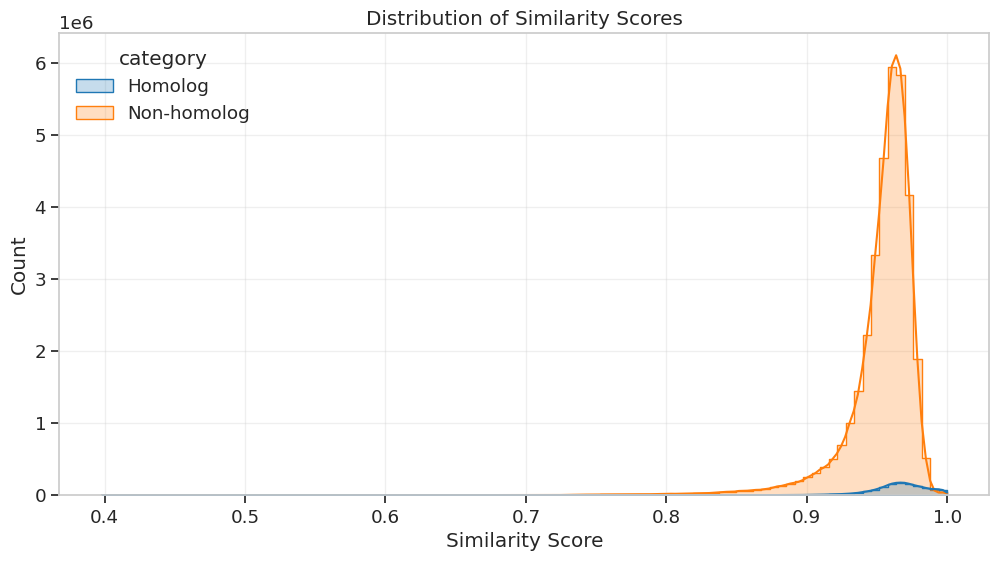

In [5]:
# Plot score distributions
plt.figure(figsize=(12, 6))
sns.histplot(data=results_df, x='score', hue='category', bins=100, kde=True, element='step')
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.savefig(os.path.join(combined_dir, 'score_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

## ROC Curve Analysis

In [7]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

# Find optimal threshold using Youden's J statistic
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_metrics = {
    'tpr': tpr[optimal_idx],
    'fpr': fpr[optimal_idx],
    'threshold': optimal_threshold
}

# Calculate precision and recall
precision, recall, pr_thresholds = precision_recall_curve(labels, scores)
avg_precision = average_precision_score(labels, scores)

# Calculate F1 score at optimal threshold
y_pred = (scores >= optimal_threshold).astype(int)
from sklearn.metrics import f1_score, precision_score
optimal_metrics['f1_score'] = f1_score(labels, y_pred)
optimal_metrics['precision'] = precision_score(labels, y_pred)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Optimal threshold (Youden's J): {optimal_threshold:.4f}")
print(f"At this threshold:")
print(f"  TPR (Sensitivity): {optimal_metrics['tpr']:.4f}")
print(f"  FPR: {optimal_metrics['fpr']:.4f}")
print(f"  Precision: {optimal_metrics['precision']:.4f}")
print(f"  F1 Score: {optimal_metrics['f1_score']:.4f}")

# Save ROC data
np.savez(os.path.join(combined_dir, 'combined_roc_data.npz'),
         fpr=fpr, tpr=tpr, thresholds=thresholds, auc=roc_auc)

# Save PR data
np.savez(os.path.join(combined_dir, 'combined_pr_data.npz'),
         precision=precision, recall=recall, thresholds=pr_thresholds, 
         avg_precision=avg_precision, optimal_threshold=optimal_threshold)


ROC AUC: 0.6555
Average Precision: 0.1718
Optimal threshold (Youden's J): 0.9721
At this threshold:
  TPR (Sensitivity): 0.3842
  FPR: 0.1415
  Precision: 0.0902
  F1 Score: 0.1461


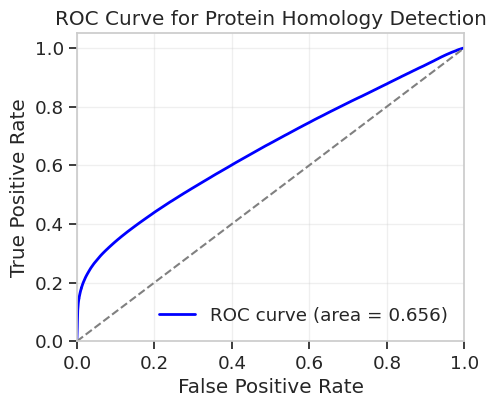

In [9]:
# Load ROC data
roc_data = np.load(os.path.join(combined_dir, 'combined_roc_data.npz'))
fpr = roc_data['fpr']
tpr = roc_data['tpr']
thresholds = roc_data['thresholds']
roc_auc = roc_data['auc']

# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Protein Homology Detection')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## Inverse ROC Analysis

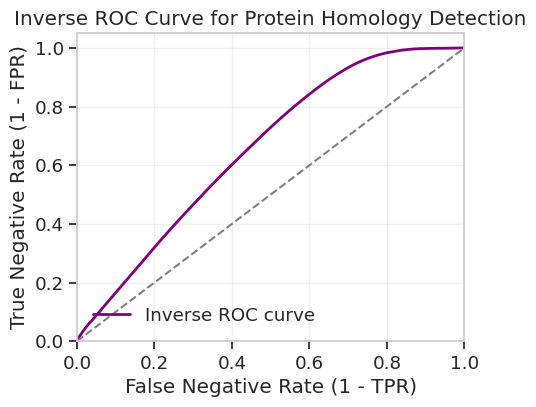

In [20]:
# Calculate inverse ROC metrics
# True Negative Rate (TNR) = 1 - FPR
tnr = 1 - fpr
# False Negative Rate (FNR) = 1 - TPR
fnr = 1 - tpr

# Plot inverse ROC curve (TNR vs FNR)
plt.figure(figsize=(5, 4))
plt.plot(fnr, tnr, color='purple', lw=2, label=f'Inverse ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Negative Rate (1 - TPR)')
plt.ylabel('True Negative Rate (1 - FPR)')
plt.title('Inverse ROC Curve for Protein Homology Detection')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()

# Save inverse ROC data
np.savez(os.path.join(combined_dir, 'combined_inverse_roc_data.npz'),
         fnr=fnr, tnr=tnr, thresholds=thresholds)


## Precision-Recall Curve Analysis

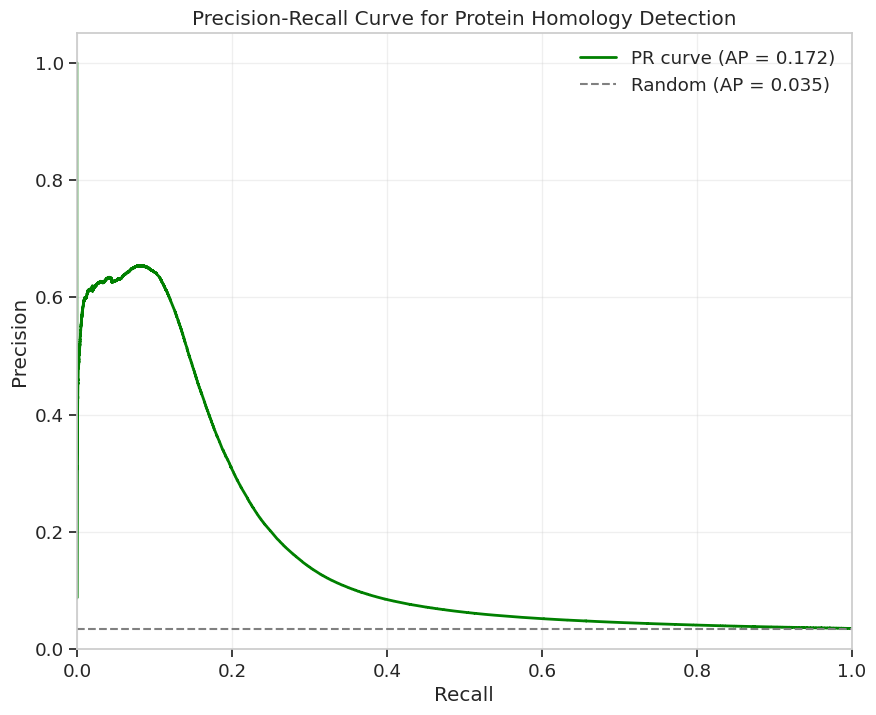

In [11]:
# Load PR data
pr_data = np.load(os.path.join(combined_dir, 'combined_pr_data.npz'))
precision = pr_data['precision']
recall = pr_data['recall']
pr_thresholds = pr_data['thresholds']
avg_precision = pr_data['avg_precision']

# Plot PR curve
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {avg_precision:.3f})')

# Calculate baseline (random classifier)
baseline = np.sum(labels) / len(labels)
plt.axhline(y=baseline, color='gray', linestyle='--', label=f'Random (AP = {baseline:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Protein Homology Detection')
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.show()

## Optimal Threshold Analysis

In [14]:
# Create separate DataFrames for ROC and PR metrics
roc_df = pd.DataFrame({
    'threshold': thresholds,
    'fpr': fpr,
    'tpr': tpr
})

pr_df = pd.DataFrame({
    'threshold': pr_thresholds,
    'precision': precision[:-1],  # Precision-recall curve has one more point than thresholds
    'recall': recall[:-1]
})

# Calculate F1 scores for the PR curve data
pr_df['f1_score'] = 2 * (pr_df['precision'] * pr_df['recall']) / (pr_df['precision'] + pr_df['recall'] + 1e-10)

# Calculate Youden's J statistic using ROC data
roc_df['youden_j'] = roc_df['tpr'] - roc_df['fpr']

# Find optimal threshold based on Youden's J statistic
optimal_idx = roc_df['youden_j'].idxmax()
optimal_threshold = roc_df.loc[optimal_idx, 'threshold']
optimal_metrics = roc_df.loc[optimal_idx]

# Find closest threshold in PR data to get corresponding precision/recall
closest_pr_idx = (np.abs(pr_df['threshold'] - optimal_threshold)).idxmin()
optimal_pr_metrics = pr_df.loc[closest_pr_idx]

print(f"Optimal threshold (Youden's J): {optimal_threshold:.4f}")
print(f"At this threshold:")
print(f"  TPR (Sensitivity): {optimal_metrics['tpr']:.4f}")
print(f"  FPR: {optimal_metrics['fpr']:.4f}")
print(f"  Precision: {optimal_pr_metrics['precision']:.4f}")
print(f"  F1 Score: {optimal_pr_metrics['f1_score']:.4f}")

# For subsequent cells, use roc_df instead of threshold_df
threshold_df = roc_df

Optimal threshold (Youden's J): 0.9721
At this threshold:
  TPR (Sensitivity): 0.3842
  FPR: 0.1415
  Precision: 0.0902
  F1 Score: 0.1461


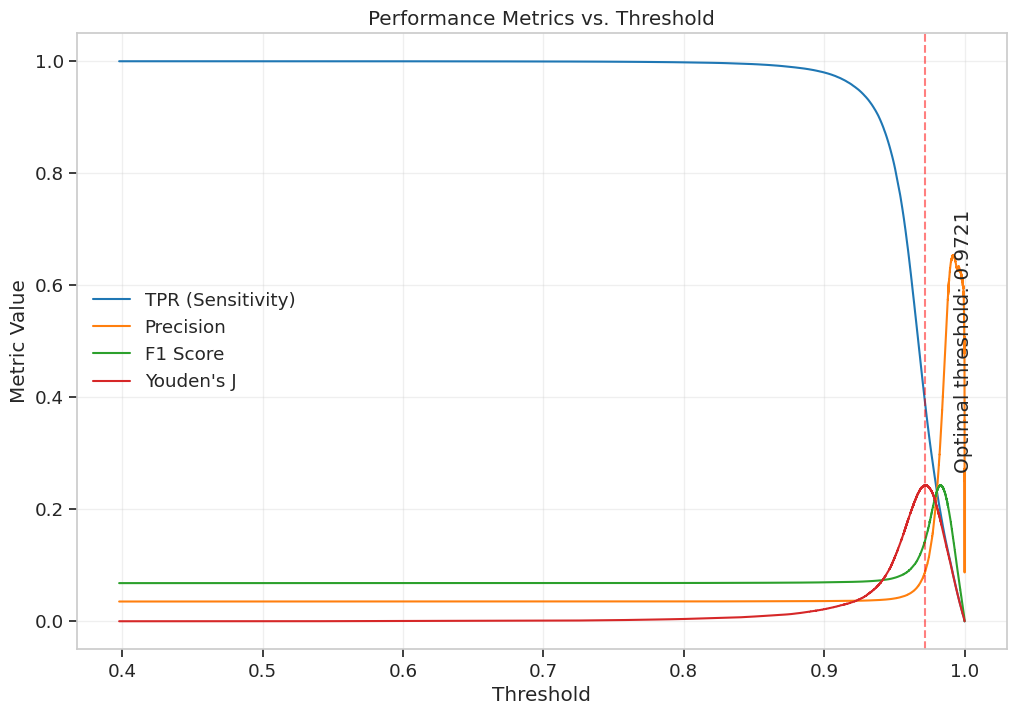

In [16]:
# Plot metrics vs threshold
plt.figure(figsize=(12, 8))
plt.plot(threshold_df['threshold'], threshold_df['tpr'], label='TPR (Sensitivity)')
# Use pr_df for precision and f1_score since they're not in threshold_df (which is roc_df)
plt.plot(pr_df['threshold'], pr_df['precision'], label='Precision')
plt.plot(pr_df['threshold'], pr_df['f1_score'], label='F1 Score')
plt.plot(threshold_df['threshold'], threshold_df['youden_j'], label="Youden's J")

# Mark optimal threshold
plt.axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.5)
plt.text(optimal_threshold + 0.02, 0.5, f'Optimal threshold: {optimal_threshold:.4f}', 
         rotation=90, verticalalignment='center')

plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Performance Metrics vs. Threshold')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.savefig(os.path.join(combined_dir, 'threshold_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

## Confusion Matrix at Optimal Threshold

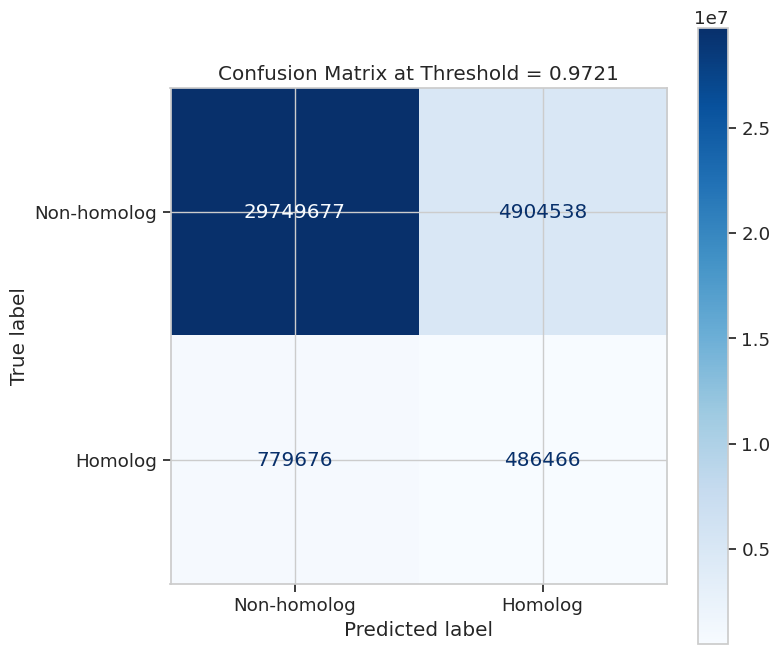

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict using optimal threshold
y_pred = (scores >= optimal_threshold).astype(int)

# Create confusion matrix
cm = confusion_matrix(labels, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-homolog', 'Homolog'])
disp.plot(cmap='Blues', values_format='d', ax=ax)
plt.title(f'Confusion Matrix at Threshold = {optimal_threshold:.4f}')
plt.savefig(os.path.join(combined_dir, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

## Summary Statistics

In [19]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(labels, y_pred, target_names=['Non-homolog', 'Homolog'])
print("Classification Report at Optimal Threshold:")
print(report)

# Calculate precision and F1 score directly
y_pred_array = np.array(y_pred)
labels_array = np.array(labels)
true_positives = np.sum((y_pred_array == 1) & (labels_array == 1))
false_positives = np.sum((y_pred_array == 1) & (labels_array == 0))
false_negatives = np.sum((y_pred_array == 0) & (labels_array == 1))

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Save summary statistics
with open(os.path.join(combined_dir, 'summary_statistics.txt'), 'w') as f:
    f.write(f"Total samples: {len(scores)}\n")
    f.write(f"Positive samples: {np.sum(labels)} ({np.sum(labels)/len(labels)*100:.2f}%)\n\n")
    f.write(f"ROC AUC: {roc_auc:.4f}\n")
    f.write(f"Average Precision: {avg_precision:.4f}\n\n")
    f.write(f"Optimal threshold (Youden's J): {optimal_threshold:.4f}\n")
    f.write(f"At this threshold:\n")
    f.write(f"  TPR (Sensitivity): {optimal_metrics['tpr']:.4f}\n")
    f.write(f"  FPR: {optimal_metrics['fpr']:.4f}\n")
    f.write(f"  Precision: {precision:.4f}\n")
    f.write(f"  F1 Score: {f1:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(report)

Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

 Non-homolog       0.97      0.86      0.91  34654215
     Homolog       0.09      0.38      0.15   1266142

    accuracy                           0.84  35920357
   macro avg       0.53      0.62      0.53  35920357
weighted avg       0.94      0.84      0.89  35920357

